# Final Project Foundamentals of Data Science
### Solar Eclipse phases classification
#### Luca Moresca, Nicholas Suozzi, Valerio Santini

---------
-   **Titolo del progetto:** Classificazione delle fasi dell'eclissi solare 
-   **Autori:** Luca Moresca, Nicholas Suozzi, Valerio Santini
-   **Descrizione del problema:** Fornire una breve panoramica del problema della classificazione delle fasi dell'eclissi solare. Evidenziare l'importanza dello studio delle eclissi solari per la comprensione dell'interazione tra Sole e Terra.
-   **Obiettivo del progetto:** Definire chiaramente l'obiettivo del progetto, ovvero sviluppare un modello in grado di classificare accuratamente le diverse fasi di un'eclissi solare da immagini.


### Abstract


In [4]:
if True:
    %pip install -qqq numpy scipy matplotlib pandas scikit-learn seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [104]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
from pathlib import Path
import json
from PIL import Image
from scipy.signal import convolve2d
import math
from scipy.ndimage import convolve1d
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from skimage import io, color
from skimage.measure import label, regionprops
from skimage.draw import rectangle
from skimage.filters import threshold_otsu
from typing import List, Tuple, Optional, Dict, Union
%load_ext autoreload
%autoreload 2

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Dataset Analysis

The “Great American Eclipse” in 2017 offered a unique opportunity for US citizens across the entire continent to experience the awe-inspiring changes that occur during rare total solar eclipses (TSEs). The goal of the 2017 Eclipse Megamovie was to obtain enough pictures of the Great American Total Solar Eclipse to create a movie of the solar corona in order to better study it. Over 2,000 volunteers submitted 50,000 images and a movie was made only a few hours after the Moon's shadow left the U.S. A few months later another, better aligned and more closely edited, movie was released. The Eclipse Megamovie team of scientists processed images to create High Dynamic Range (HDR) images to capture the structures within the high dynamic range of the solar corona from the Sun's photosphere out ~3 solar radii.
https://eclipsemegamovie.org

Eclipse megamovie is a project being carried out by a group of researchers in collaboration with NASA. The focus of this project is to make a video that can facilitate research into a rare event such as the eclipse that occurred in the United States in 2017. To realise this project, American citizens were asked to send in photographs taken during the eclipse. The dataset therefore contains semi-professional and amateur images, taken under conditions that are not always optimal.

In [6]:
# Print the .json file with the label.
with open('eclipse-megamovie/label_num_to_phase_map.json', 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))


{
    "TotalSolarEclipse": 0,
    "0to25percentPartialEclipse": 1,
    "26to55percentPartialEclipse": 2,
    "56to95percentPartialEclipse": 3,
    "Darks": 4,
    "DiamondRing_BaileysBeads_SolarEclipse": 5,
    "Flats": 6,
    "NotASolarEclipse": 7
}


In [7]:
# Print the .csv file with labels and images names.
df = pd.read_csv("eclipse-megamovie/train.csv")
print(df)

                                              image_id  label
0    0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1    00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2    ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3    eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4    fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0
..                                                 ...    ...
490  4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba...      7
491  fb9026a6d96719729ef44c61e76c5b007b17784f6ddb8f...      7
492  0160498b80fcf8f55002627f1f3eb7c6969675f7877410...      7
493  021c7d3386821090186bd925a8d13d9cc509db69550956...      7
494  018b72bf1ef4f3a184c0029ffcff3dde17f4a883ef472f...      7

[495 rows x 2 columns]


The .json file relates the eclipse phases to the corresponding labels in the ‘train.csv’ file, which will help the training phase by already having a correspondence between label and image. The csv file then contains a classification of the various training images useful for the model. 

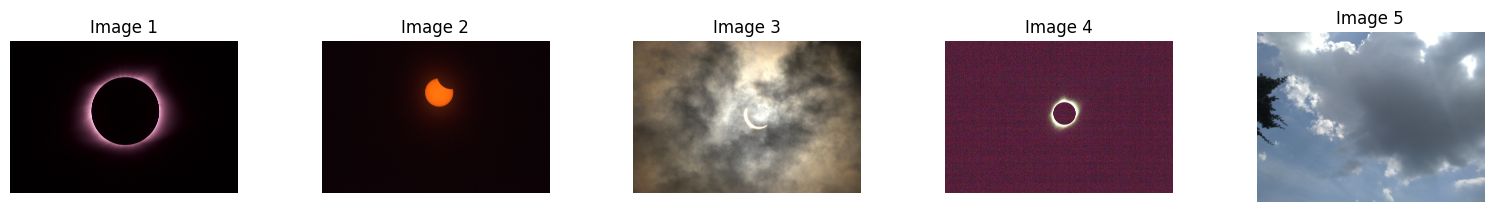

In [8]:
# Plot of some images in the train dataset

img1 = mpimg.imread('eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg')
img2 = mpimg.imread('eclipse-megamovie/train/00a4af4cc3f2a667c80331051a733e8dae2477d682d7dcef3e895f6f923dd86a.jpg')
img3 = mpimg.imread('eclipse-megamovie/train/00c11b16fd6426a88039c8b27e2511e2e770b65e0eb9daab720d3e6ca996bc06.jpg')
img4 = mpimg.imread('eclipse-megamovie/train/001e6704a60798684f1656713b593e6a56de81474e7173a31936589cd62f13e8.jpg')
img5 = mpimg.imread('eclipse-megamovie/train/4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba0df5436a7de70dc16e.jpg')

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.tight_layout(pad=3.0)

axes[0].imshow(img1)
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Image 2")
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title("Image 3")
axes[2].axis('off')

axes[3].imshow(img4)
axes[3].set_title("Image 4")
axes[3].axis('off')

axes[4].imshow(img5)
axes[4].set_title("Image 5")
axes[4].axis('off')

plt.show()


* As can be seen in the figure above, our dataset consists of various types of images. Some contain eclipses, others do not. The images have different perspectives, are taken with different devices and have different backgrounds. 
This presents us with the challenge of correctly identifying the content of each image accurately, we must be able to classify images that do not contain eclipses as impostors. 
On a numerical level, the dataset consists of a training set and a test set. In addition, there is a .csv file containing the name of some images and a label showing the corresponding eclipse phase. In addition, there is a .json file that explains what each label corresponds to on a phase level. 
There are 496 images in the training set and 140 images in the test set. The dataset is restricted and this will result in an appropriate treatment of the images to improve the performance of the model. 

* Each image has a different resolution, considering that they are obtained with various devices. The eclipse within each image is not always perfectly sharp or centred, making the model more elastic in various cases.


## 2. Preprocessing delle immagini

-   **Spiegazioni:** Descrivere le tecniche di preprocessing delle immagini utilizzate, spiegando la logica alla base di ogni scelta.
-   Ad esempio, se si ridimensionano le immagini, spiegare perché è necessario farlo e quale dimensione si è scelto di utilizzare.
-   Se si convertono le immagini in scala di grigi, giustificare questa scelta.
-   Se si normalizzano i valori dei pixel, spiegare il metodo di normalizzazione utilizzato e perché è importante.
-   **Codice:** Fornire il codice Python utilizzato per il preprocessing delle immagini.
-   **Visualizzazioni:** Mostrare alcuni esempi di immagini pre-elaborate, confrontandole con le immagini originali.


### Suggerimenti per il Preprocessing delle Immagini per la Classificazione delle Fasi di Eclissi Solare

Ecco alcuni suggerimenti per descrivere le tecniche di preprocessing delle immagini che potresti utilizzare per il tuo progetto di classificazione delle fasi di eclissi solare, insieme alla logica alla base di ogni scelta:

*   **Conversione in scala di grigi:** La conversione delle immagini in scala di grigi è una scelta comune nel preprocessing delle immagini, soprattutto quando il colore non è una caratteristica discriminante per il compito in questione. Nel caso della classificazione delle fasi di eclissi solare, le informazioni di colore potrebbero non essere essenziali per distinguere le diverse fasi. La conversione in scala di grigi riduce la complessità dei dati e la quantità di informazioni da elaborare, il che può accelerare i tempi di addestramento del modello e potenzialmente migliorare le sue prestazioni.
*   **Riduzione del rumore:** Le immagini possono contenere rumore che può influenzare negativamente le prestazioni del modello. La riduzione del rumore può essere realizzata utilizzando filtri come il filtro gaussiano.  Applicare un filtro gaussiano prima di altre operazioni di preprocessing può aiutare a migliorare la qualità delle immagini e a rendere più evidenti le caratteristiche importanti per la classificazione.
*   **Downscaling:**  Se le immagini originali hanno una risoluzione molto alta, il downscaling può essere utile per ridurre la quantità di dati da elaborare e accelerare i tempi di addestramento. La dimensione da utilizzare dipenderà dalla risoluzione originale delle immagini e dalla complessità del modello. È importante scegliere una dimensione che conservi le caratteristiche essenziali per la classificazione, evitando al contempo di perdere troppe informazioni.  Assicurati di applicare un filtro gaussiano prima del downscaling per evitare l'aliasing. 
*   **Normalizzazione:** La normalizzazione dei valori dei pixel è un'altra tecnica comune nel preprocessing delle immagini.  Può essere eseguita sottraendo la media e dividendo per la deviazione standard dei valori dei pixel. Questo processo porta tutti i valori dei pixel in un intervallo simile, il che può aiutare a migliorare le prestazioni del modello, soprattutto quando si utilizzano algoritmi di apprendimento automatico sensibili alla scala dei dati.

**Tecniche utili dagli homework:**

*   **Dal Homework 1:** Tutte le tecniche elencate (riduzione del rumore, downscaling, normalizzazione e conversione in scala di grigi) possono essere utili per il tuo progetto.
*   **Dal Homework 2:** La codifica one-hot sarà necessaria per le etichette delle fasi dell'eclissi. La gestione dei valori mancanti potrebbe essere utile se il tuo set di dati contiene immagini incomplete o danneggiate. L'espansione polinomiale e lo scaling potrebbero non essere necessari per il tuo progetto, in quanto sono tecniche più comunemente utilizzate per dati numerici non immagine.

### Tecniche Essenziali di Preprocessing per Immagini di Eclissi Solari Variabili

Dato che si ha a che fare con una vasta gamma di immagini scattate da amatori, che presentano diverse proporzioni, dimensioni del sole e posizioni del sole all'interno dell'immagine, è fondamentale applicare tecniche di preprocessing essenziali per preparare i dati per l'addestramento del modello di classificazione delle fasi dell'eclissi. 

Oltre alle tecniche di base già discusse (conversione in scala di grigi, riduzione del rumore, downscaling e normalizzazione), ecco alcune altre tecniche molto essenziali da considerare:

*   **Ritaglio e ridimensionamento:** Le immagini potrebbero avere bordi o aree irrilevanti che non contribuiscono alla classificazione delle fasi dell'eclissi. Il ritaglio può essere utilizzato per rimuovere queste aree e focalizzare l'attenzione sulla regione di interesse, ovvero il sole e la corona solare. Dopo il ritaglio, tutte le immagini dovrebbero essere ridimensionate a una dimensione uniforme per garantire la compatibilità con il modello. Poiché le proporzioni delle immagini originali possono variare, è possibile utilizzare un ridimensionamento con padding per mantenere le proporzioni originali, aggiungendo bordi neri attorno all'immagine ritagliata per raggiungere la dimensione desiderata. 
*   **Centratura del Sole:** La posizione del sole all'interno dell'immagine può variare notevolmente. Per migliorare le prestazioni del modello, è utile centrare il sole in tutte le immagini. Ciò può essere ottenuto tramite algoritmi di rilevamento degli oggetti o, in casi più semplici, analizzando l'istogramma dell'immagine per identificare la regione più luminosa (presumibilmente il sole) e spostarla al centro dell'immagine.

### Come Rilevare e Centrare il Sole nelle Immagini di Eclissi

Per centrare il sole in un'immagine, un metodo robusto è quello di utilizzare la **combinazione di rilevamento dei bordi, piramide gaussiana e template matching**, tecniche già presenti negli homework forniti.

**Ecco i passaggi**

1. **Rilevamento dei Bordi**

2. **Piramide Gaussiana** 

3. **Template Matching** 

4. **Selezione della Scala Migliore** 

5. **Centratura** 

**Note Aggiuntive**

* Per migliorare ulteriormente la precisione del rilevamento, è possibile utilizzare un template del sole più sofisticato, che tenga conto della corona solare.
* Dopo la centratura, potrebbe essere necessario ritagliare l'immagine per rimuovere eventuali bordi neri aggiunti durante il ridimensionamento con padding.

Questo metodo offre una soluzione efficace per rilevare e centrare il sole in immagini di eclissi solare, utilizzando tecniche già familiari dagli homework e garantendo una buona robustezza e flessibilità.




### Conversione in scala di grigi 

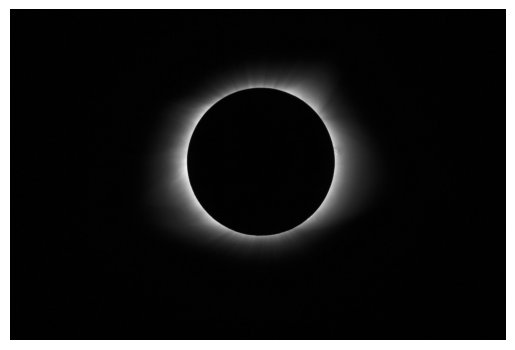

In [133]:
import cv2

# path = "eclipse-megamovie/train/00ba63d5209247263081129630bfdf25e9dfcf79e068019318318fd7dee81f06.jpg"
path = "eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg"
image = cv2.imread(path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# cv2.imwrite('/Users/valeriosantini/Desktop/or.jpg', image)
# cv2.imwrite('/Users/valeriosantini/Desktop/gr.jpg', gray_image)

plt.imshow(gray_image, cmap="gray")
plt.axis('off')
plt.show()




COMMENTARE

### Normalizzazione

### Denoising

In [134]:
def gauss(sigma: float, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    Gx = np.array([])
    k = (filter_size - 1) // 2  
    x = np.arange(-k, k + 1)
    cost = 1/(np.sqrt(2*np.pi)*sigma)
    Gx = np.append(Gx, cost * np.exp(-(x**2)/(2*sigma**2)))
    return Gx, x

def gaussfiltering(img: np.ndarray, sigma: float) -> np.ndarray:
    filter_size = np.round(6 * sigma)

    Gx, _ = gauss(sigma, filter_size)
    out = convolve1d(img, Gx, axis = 1)
    out = convolve1d(out, Gx, axis = 0)
    
    return out

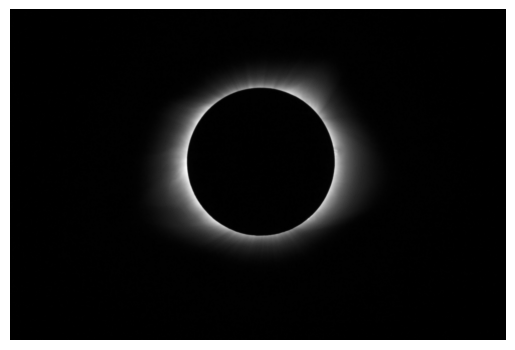

In [135]:
sigma = 3

smt_img = gaussfiltering(gray_image, sigma)

plt.imshow(smt_img, cmap="gray")
plt.axis('off')
plt.show()

COMMENTARE


### Normalization

In [136]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

In [137]:
nrm_img = normalize(smt_img)

### Eclipse Isolation

In [138]:
def detect_eclipse(image):

    hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 1))
    plt.figure(figsize=(10, 4))
    plt.title("Istogramma delle Intensità")
    plt.bar(bins[:-1], hist, width=0.005, color='gray')
    plt.xlabel("Intensità")
    plt.ylabel("Numero di pixel")
    plt.show()

    offset = 15

    intensity_threshold = threshold_otsu(image)

    bright_pixels = image > intensity_threshold

    labeled_bright = label(bright_pixels)
    regions = regionprops(labeled_bright)


    if len(regions) == 0:
        print("Nessuna regione luminosa rilevata.")
        return None
    largest_region = max(regions, key=lambda r: r.area)
    minr, minc, maxr, maxc = largest_region.bbox


    detected_image = np.copy(image)
    detected_image[bright_pixels] = 1  
    detected_image[minr:maxr, minc:maxc] = 1  

    cropped_image = image[minr:maxr, minc:maxc]

    # Mostrare i risultati
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Regione Luminosa Rilevata")
    plt.imshow(detected_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Immagine Ritagliata")
    plt.imshow(cropped_image, cmap='gray')
    plt.show()

    return cropped_image


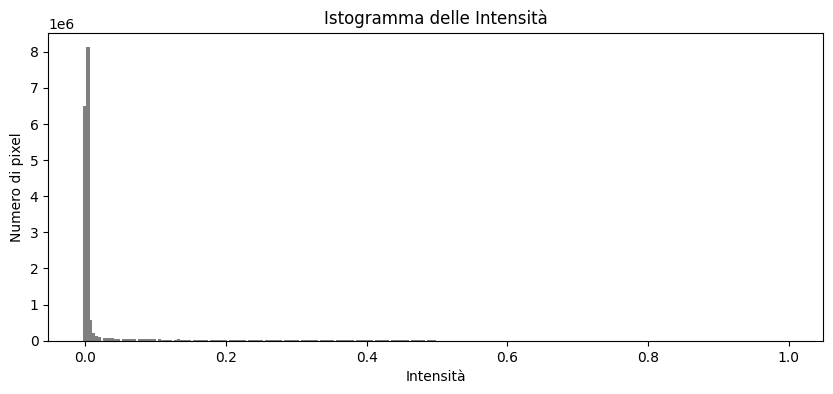

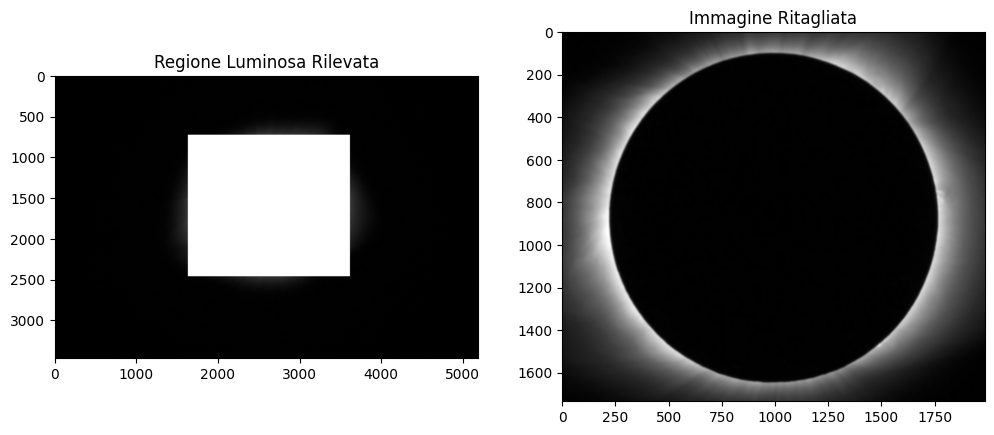

In [139]:
cropped_img = detect_eclipse(nrm_img)

### Downscaling

In [ ]:
def downscale(
    img: np.ndarray,
    factor: float,
    steps:int=3,
    sigma:float=1
    ) -> np.ndarray:

    imgs = [img]
    blurred = []

    for i in range(steps):
        if img.ndim == 3:  
            img_blurred = np.zeros_like(img)
            for c in range(3):
                img_blurred[:, :, c] = gaussfiltering(img[:, :, c], sigma)
        else: 
            img_blurred = gaussfiltering(img, sigma)

        blurred.append(img_blurred)
        N, M = img.shape[:2]
        N = N // factor
        M = M // factor
        img = resize(img_blurred, (N, M))
        
        imgs.append(img)
    
    if img.ndim == 3:  
        imgs = [np.clip(img * 255, 0, 255).astype(np.uint8) for img in imgs]
        blurred = [np.clip(img * 255, 0, 255).astype(np.uint8) for img in blurred]
        
    return imgs, blurred

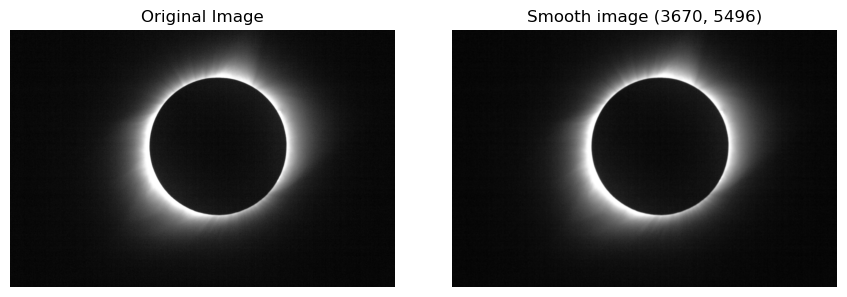

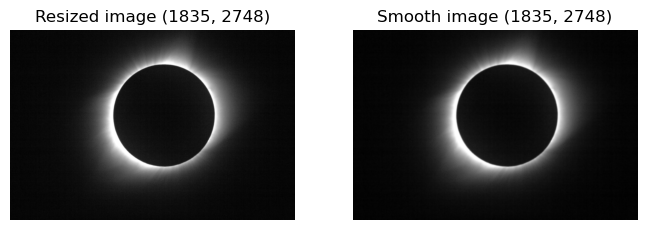

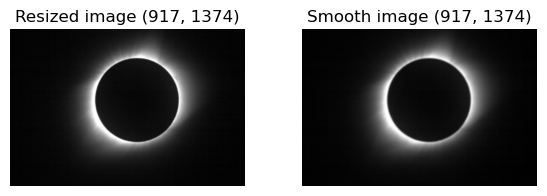

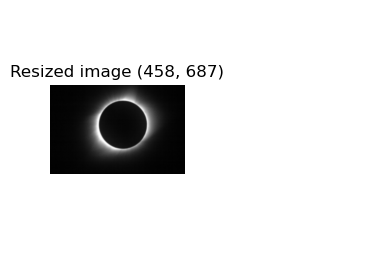

In [ ]:
STEPS = 3
imgs, img_blur = downscale(smt_img, 2, steps=STEPS, sigma=3)

for i in range(STEPS+1):
    fig, axes = plt.subplots(1, 2, figsize=(int(12* .8**(i+1)),int(8* .8**(i+1))))
    plt.gray()
    fig.tight_layout()
    axes[0].imshow(imgs[i])
    axes[0].set_title(f"Resized image {imgs[i].shape}" if i != 0 else "Original Image")
    axes[0].axis('off')
    if i < STEPS:
        axes[1].imshow(img_blur[i])
        axes[1].set_title(f"Smooth image {img_blur[i].shape}")
    axes[1].axis('off')

## 3. Estrazione delle feature

-   **Istogrammi:Spiegazioni:** Spiegare come gli istogrammi possono essere utilizzati per estrarre feature dalle immagini di eclissi solare. [1]
-   Descrivere come la distribuzione dei pixel nell'istogramma può variare a seconda della fase dell'eclissi.
-   **Codice:** Fornire il codice Python utilizzato per calcolare gli istogrammi.
-   **Visualizzazioni:** Mostrare alcuni esempi di istogrammi per le diverse fasi dell'eclissi.
-   **Altre tecniche (opzionale):** Se si utilizzano altre tecniche di estrazione delle feature, includere una sezione simile a quella degli istogrammi, spiegando e visualizzando i risultati.

## 4. Scelta e implementazione del modello

-   **Modello scelto:** Indicare chiaramente il modello di classificazione scelto per il progetto (ad esempio, Regressione Logistica, Regressione Softmax, CNN). [4-6]
-   Giustificare la scelta del modello in base alle caratteristiche del problema e del dataset.
-   Fornire una breve descrizione teorica del modello scelto, evidenziandone i principi di funzionamento.
-   **Codice:** Fornire il codice Python utilizzato per implementare il modello.
-   Utilizzare le competenze acquisite durante la realizzazione di "HomeWork.pdf" per implementare il modello in modo efficiente. [7]
-   Commentare il codice in modo chiaro per renderlo comprensibile.
-   **Training del modello:Spiegazioni:** Descrivere la procedura di training del modello, specificando la funzione di loss, l'algoritmo di ottimizzazione e gli iperparametri utilizzati. [8-20]
-   Spiegare come si è divisa il dataset in set di training e di test.
-   **Codice:** Fornire il codice Python utilizzato per il training del modello.
-   **Visualizzazioni:** Mostrare l'andamento della funzione di loss durante il training. [21-27]
-   Plottare anche l'accuratezza sul set di training e sul set di test durante il training.


## 5. Valutazione del modello

-   **Spiegazioni:** Descrivere le metriche utilizzate per valutare le prestazioni del modello. [13, 28-32]
-   Oltre all'accuratezza, considerare altre metriche come precisione, recall e F1-score, soprattutto se si ha uno sbilanciamento di classe.
-   **Codice:** Fornire il codice Python utilizzato per calcolare le metriche di valutazione.
-   **Risultati:** Presentare i risultati ottenuti dal modello sul set di test.
-   Utilizzare tabelle e grafici per visualizzare i risultati in modo chiaro ed efficace.
-   **Discussione:** Analizzare i risultati ottenuti, commentando le prestazioni del modello e le eventuali limitazioni.

## 6. Video delle transizioni dell'eclissi (opzionale) 

-   **Spiegazioni:** Descrivere il processo di creazione del video, includendo il software utilizzato e le scelte creative fatte.
-   Spiegare come si sono selezionate le immagini per il video e come si è creata la sequenza di transizione.
-   **Video:** Includere il video nel notebook Jupyter.

## 7. Conclusioni

-   **Riepilogo:** Riassumere brevemente il lavoro svolto nel progetto.
-   **Risultati principali:** Evidenziare i risultati più importanti ottenuti.
-   **Sviluppi futuri:** Suggerire eventuali miglioramenti o sviluppi futuri del progetto.